## Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

Plan:
* Study how to use OpenAI gym
* Basic prototype of evolutionary strategies that works in one thread on CartPole
* Modify the code to make them work in parallel
* Use the algorithm to solve the LunarLander
* Analyse the influence of hyperparameters

In [2]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
from copy import deepcopy
 
%matplotlib inline

# OpenAI gym environment

Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Discrete(2)


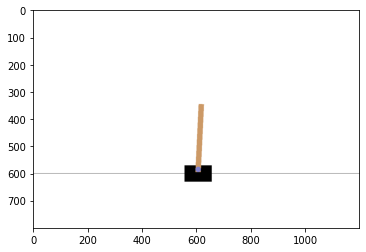

In [4]:
import gym

tmp_env = gym.make("CartPole-v0")
tmp_env.reset()

plt.imshow(tmp_env.render('rgb_array'))
print("Observation space:", tmp_env.observation_space)
print("Action space:", tmp_env.action_space)
state_size = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

### How to interact with the environment

In [5]:
print("Initial observation:", tmp_env.reset())

new_s, reward, done, _ = tmp_env.step(0)
print("At each step it returns:")

print("new observation code:", new_s)
print("reward:", reward)
print("is game over?:", done)

Initial observation: [-0.0236421  -0.04408319  0.02501969  0.00062542]
At each step it returns:
new observation code: [-0.02452376 -0.23955486  0.0250322   0.30109618]
reward: 1.0
is game over?: False


### Display an episode

In [6]:
def display_session(env, agent, t_max=500):
    total_reward = 0
    plt.figure(figsize=(4, 3))
    display.clear_output(wait=True)

    s = env.reset()
    
    for t in range(t_max):
        plt.gca().clear()
        
        a = agent.get_action(torch.tensor(s).float())[0]
        new_s, r, done, info = env.step(a)
        s = new_s
        total_reward += r
        # Draw game image on display.
        plt.imshow(env.render('rgb_array'))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            break
            
    return total_reward

### Random policy

In [7]:
class RandomPolicy:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        
    def get_action(self, state: torch.Tensor):
        action = np.random.choice(range(self.n_actions))
        return action

IndexError: invalid index to scalar variable.

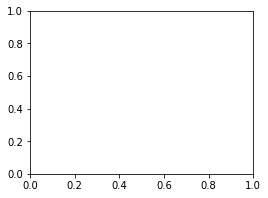

In [8]:
total_reward = display_session(tmp_env, RandomPolicy(n_actions))
print('Total reward: ', total_reward)

# The challenge of the day

![Algorithm](https://i.ibb.co/zFm6BrB/Screenshot-from-2021-09-17-13-38-00.png)

### Model evaluation

In [9]:
def generate_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())[0]
        new_s, r, done, info = env.step(a)
        total_reward += r
        s = new_s
        
        if done:
            break
            
    return total_reward


# def score(env, agent, n=10, t_max=500):
#     pass

### Modification of the model using a noise 

In [10]:
def add_noise_to_model(model, noise, copy=False):
    if copy:
        model = deepcopy(model)
    
    new_weight = model.fc.weight + noise.T
    model.fc.weight = nn.Parameter(new_weight.float())
    return model

### Controller of the evolution

#### Task 1: Implement the algorithm

In [16]:
class EvolutionManager:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        
        self.env = get_env_function()
        
    def get_noised_model(self, model, noise):
        return add_noise_to_model(model, noise, True)
    
    @torch.no_grad()
    def optimize(self, model, noises):
        noised_models = [self.get_noised_model(model, self.std*noise) for noise in noises]
        rewards = [generate_session(self.env, noised_model) for noised_model in noised_models]
        rewards = np.array(rewards)
        
        A = (rewards - np.mean(rewards)) / np.std(rewards)
        
        new_noise = self.lr/(self.n_samples*self.std) * np.dot(noises.T, A)
        new_model = add_noise_to_model(model, new_noise.T)
        return new_model, rewards
    
    def step(self, model):
        noises = np.random.randn(self.n_samples, n_states, n_actions)  
        new_model, rewards = self.optimize(model, noises)
        self.update_log(rewards)
        
    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
#         self.mean_reward_history.append(mean_reward)

#         clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
#         plt.figure(figsize=[8, 4])
#         plt.subplot(1, 2, 1)
#         plt.plot(self.mean_reward_history, label='Mean rewards')
#         plt.legend()
#         plt.grid()

#         plt.subplot(1, 2, 2)
#         plt.hist(rewards)
#         plt.grid()

#         plt.show()
    

#### Task 2: Implement a neural network-based policy

### Neural policy

In [12]:
class MLPPolicy(nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()
        self.fc = nn.Linear(n_states, n_actions)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        out = self.fc(x)
        out = self.softmax(out)
        return out
    
    def get_action(self, states):
        probs = self(states)
        probs = probs.detach().numpy()
        action = np.random.choice(np.arange(n_actions), size = 1, p = probs)
        return action

### Environment 1: CartPole-v0

In [13]:
def get_env_function():
    env = gym.make('CartPole-v0').env
    return env
tmp_env = get_env_function()

In [17]:
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n
model = MLPPolicy(n_states, n_actions)

In [18]:
noises = np.random.randn(128, n_states, n_actions)

In [19]:
algorithm = EvolutionManager(get_env_function, lr=0.01, std=0.1, n_samples = 64)

t = time.time()
for i in range(1000):
    algorithm.step(model)
    
print(time.time() - t)

/var/folders/lm/flgwr_ks0cn6xv9bcn3f_d2m0000gn/T/ipykernel_50500/1972564403.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


last mean reward = 18.188
last mean reward = 18.281
last mean reward = 17.688
last mean reward = 19.953
last mean reward = 19.578
last mean reward = 17.328
last mean reward = 18.406
last mean reward = 19.359
last mean reward = 19.328
last mean reward = 19.875
last mean reward = 19.406
last mean reward = 19.906
last mean reward = 18.281
last mean reward = 19.641
last mean reward = 19.734
last mean reward = 20.375
last mean reward = 19.812
last mean reward = 18.016
last mean reward = 20.531
last mean reward = 18.312
last mean reward = 19.422
last mean reward = 20.891
last mean reward = 20.094
last mean reward = 19.453
last mean reward = 20.922
last mean reward = 19.031
last mean reward = 20.016
last mean reward = 20.203
last mean reward = 19.469
last mean reward = 20.031
last mean reward = 22.078
last mean reward = 20.750
last mean reward = 20.438
last mean reward = 23.156
last mean reward = 19.406
last mean reward = 21.953
last mean reward = 21.562
last mean reward = 24.719
last mean re

last mean reward = 50.172
last mean reward = 52.031
last mean reward = 57.922
last mean reward = 48.891
last mean reward = 55.406
last mean reward = 59.594
last mean reward = 53.578
last mean reward = 52.188
last mean reward = 53.203
last mean reward = 52.359
last mean reward = 49.969
last mean reward = 51.641
last mean reward = 54.281
last mean reward = 49.625
last mean reward = 52.719
last mean reward = 55.016
last mean reward = 48.938
last mean reward = 53.812
last mean reward = 59.031
last mean reward = 51.234
last mean reward = 58.484
last mean reward = 57.125
last mean reward = 49.797
last mean reward = 47.797
last mean reward = 52.703
last mean reward = 52.797
last mean reward = 56.469
last mean reward = 55.094
last mean reward = 54.344
last mean reward = 57.672
last mean reward = 60.312
last mean reward = 54.312
last mean reward = 57.672
last mean reward = 55.672
last mean reward = 55.906
last mean reward = 50.969
last mean reward = 53.094
last mean reward = 51.828
last mean re

last mean reward = 74.969
last mean reward = 74.922
last mean reward = 88.281
last mean reward = 76.203
last mean reward = 83.219
last mean reward = 97.422
last mean reward = 85.609
last mean reward = 84.094
last mean reward = 81.766
last mean reward = 90.141
last mean reward = 91.234
last mean reward = 85.156
last mean reward = 79.109
last mean reward = 84.734
last mean reward = 86.484
last mean reward = 92.922
last mean reward = 88.625
last mean reward = 89.438
last mean reward = 86.828
last mean reward = 93.219
last mean reward = 86.891
last mean reward = 93.125
last mean reward = 78.859
last mean reward = 85.219
last mean reward = 95.844
last mean reward = 100.891
last mean reward = 101.641
last mean reward = 81.094
last mean reward = 91.219
last mean reward = 91.922
last mean reward = 90.156
last mean reward = 91.125
last mean reward = 83.812
last mean reward = 89.266
last mean reward = 92.719
last mean reward = 97.734
last mean reward = 95.688
last mean reward = 89.875
last mean 

last mean reward = 314.109
last mean reward = 309.734
last mean reward = 341.484
last mean reward = 333.375
last mean reward = 336.531
last mean reward = 314.000
last mean reward = 331.250
last mean reward = 326.922
last mean reward = 323.734
last mean reward = 334.156
last mean reward = 351.078
last mean reward = 335.328
last mean reward = 335.875
last mean reward = 329.281
last mean reward = 349.906
last mean reward = 331.734
last mean reward = 325.188
last mean reward = 344.297
last mean reward = 330.500
last mean reward = 344.453
last mean reward = 329.297
last mean reward = 351.594
last mean reward = 339.312
last mean reward = 340.906
last mean reward = 342.156
last mean reward = 337.312
last mean reward = 335.688
last mean reward = 324.875
last mean reward = 345.297
last mean reward = 334.703
last mean reward = 305.172
last mean reward = 306.766
last mean reward = 365.281
last mean reward = 328.797
last mean reward = 327.875
last mean reward = 351.234
last mean reward = 356.156
l

361.0

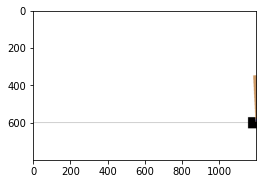

In [461]:
display_session(tmp_env, model, t_max=500)

#### Task 3: Implement and compare the parallelized version of the algorithm

### Environment 2: LunarLanderContinuous-v2

last mean reward = 155.350


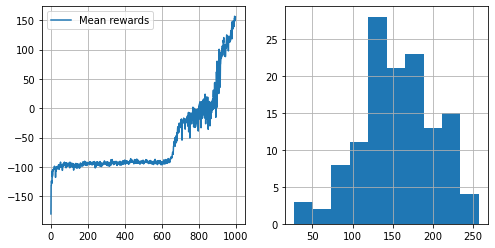

In [16]:
def get_env_function():
    env = gym.make('LunarLanderContinuous-v2').env
    return env
tmp_env = get_env_function()
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.shape[0]
model = <>
algorithm = <>
for i in range(1000):
    algorithm.step(model)

297.1928817226966

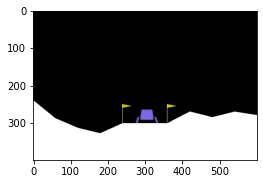

In [17]:
display_session(tmp_env, model, t_max=500)

### Task 3: Hyperparameter's analysis

Now we are going to do some experimental analysis of the algorithm.

Plan:
- to learn something about the *std* parameter
- to learn something about the *learning rate* parameter
- to learn something about the *n_samples* parameter